In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import io
import numpy as np
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from collections import namedtuple
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, SelectFromModel

In [0]:
class CategoricalSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self):
        self._feature_names = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region',
                                'TrafficType', 'SpecialDay']

        # Return self nothing else to do here

    def fit(self, X, y=None):
        return self

        # Method that describes what we need this transformer to do

    def transform(self, X, y=None):
        return X[self._feature_names]


class NumericalSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self):
        self._feature_names = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                              'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

        # Return self nothing else to do here

    def fit(self, X, y=None):
        return self

        # Method that describes what we need this transformer to do

    def transform(self, X, y=None):
        return X[self._feature_names]


class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes in a list of values as its argument
    def __init__(self):
        self.minority_traffic_types = [7, 9, 12, 14, 15, 16, 17, 18, 19]
        self.minority_browser_types = [3, 7, 9, 11, 12, 13]

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):

        # Convert minority operating systems to one "Other" category
        X.loc[:, 'OperatingSystems'] = X['OperatingSystems'].apply(lambda x: x if x < 4 else -1)
        # Convert minority traffic types to one "Other" category
        X.loc[:, 'TrafficType'] = X['TrafficType'].apply(lambda x: x if x not in self.minority_traffic_types else -1)
        # Convert minority browser types to one "Other" category
        X.loc[:, 'Browser'] = X['Browser'].apply(lambda x: x if x not in self.minority_browser_types else -1)

        return X

In [5]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
df = pd.read_csv(r"train.csv", index_col=0)

In [0]:
X, y = df.drop(['Revenue'], axis=1), df['Revenue']
y = y.apply(lambda x: 1 if x is True else 0)

# Defining the steps in the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', CategoricalSelector()),
                                        #('cat_transformer', CategoricalTransformer()),
                                        ('one_hot_encoder', OneHotEncoder(sparse=False, drop='first',
                                                                          handle_unknown='error'))])

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', NumericalSelector()),
                                      ('imputer', SimpleImputer(strategy='median')),
                                      # ('lrfe', LRFEPipeline()),
                                      ('std_scaler', StandardScaler())])

# Combining numerical and categorical piepline into one full big pipeline horizontally
# using FeatureUnion
prep_pipeline = FeatureUnion(transformer_list=[('categorical_pipeline', categorical_pipeline),
                                                ('numerical_pipeline', numerical_pipeline)])

In [14]:
features = prep_pipeline.fit_transform(X)
labels = y
print(features.shape, labels.shape)

(10480, 72) (10480,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import regularizers

Using TensorFlow backend.


Train on 7335 samples, validate on 3145 samples
Epoch 1/200
7335/7335 [==============================] - 1s 148us/sample - loss: 2.9044 - acc: 0.8368 - val_loss: 2.3427 - val_acc: 0.8665
Epoch 2/200
7335/7335 [==============================] - 1s 116us/sample - loss: 1.9813 - acc: 0.8686 - val_loss: 1.6269 - val_acc: 0.8804
Epoch 3/200
7335/7335 [==============================] - 1s 112us/sample - loss: 1.3989 - acc: 0.8774 - val_loss: 1.1584 - val_acc: 0.8871
Epoch 4/200
7335/7335 [==============================] - 1s 117us/sample - loss: 1.0165 - acc: 0.8828 - val_loss: 0.8551 - val_acc: 0.8893
Epoch 5/200
7335/7335 [==============================] - 1s 115us/sample - loss: 0.7695 - acc: 0.8848 - val_loss: 0.6576 - val_acc: 0.8909
Epoch 6/200
7335/7335 [==============================] - 1s 115us/sample - loss: 0.6104 - acc: 0.8886 - val_loss: 0.5333 - val_acc: 0.8913
Epoch 7/200
7335/7335 [==============================] - 1s 118us/sample - loss: 0.5083 - acc: 0.8881 - val_loss: 0.45

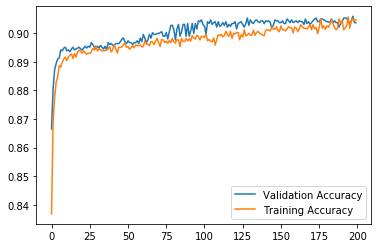

In [18]:
model = Sequential()

model.add(Dense(200, activation='relu', input_shape=(72,), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(175, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(lr=10e-5)

model.compile(optimizer=opt,
             loss='binary_crossentropy',
             metrics=['accuracy'])

h = model.fit(features, labels, epochs=200, validation_split=0.3)

plt.plot(h.history['val_acc'], label='Validation Accuracy')
plt.plot(h.history['acc'], label='Training Accuracy')
plt.legend()

In [20]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
X_test = pd.read_csv(r"test.csv", index_col=0)

In [0]:
X_test_transf = prep_pipeline.transform(X_test)

In [0]:
y_pred = model.predict(X_test_transf).ravel()

In [0]:
X_test.loc[:, 'Revenue'] = ['TRUE' if x>=0.5 else "FALSE" for x in y_pred]
X_sub = X_test[['Revenue']].copy()
X_sub.to_csv(r"C:\Users\olive\Documents\GitHub\Kaggle-ColombusRetailClassification\experiments\e5_dnn.csv")